In [1]:
#Partially adopted from Tensorflow/docs/basic_text_classification
#https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/basic_text_classification.ipynb

#As well as https://developers.google.com/machine-learning/guides/text-classification/

In [2]:
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

import numpy as np
import pandas as pd

from ParseList import parseList
from GetSeeAlso import getSeeAlso
from MakeLabels import makeLabels
from PopulateList import populateList

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
stopWords = stopwords.words('english')
from nltk import word_tokenize
stemmer = nltk.stem.SnowballStemmer('english')

[nltk_data] Downloading package punkt to /home/ldeng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ldeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#MAPPING SENTENCES TO LIBRARY
import json

#declare testLabels as an empty list
testLabels = []

#Keeping track of used sentences
used = []

#Keeping track of used sentences separately
security = []
nosecurity = []

#this is the smallest number of unique non-functional requirements of a single class
LIMIT = 270

with open("Data/Consolidated_data.txt","r") as f:
    
    #Go line by line in original data file
    for line in f:
        #find where class begins
        front = line.find("\"class\":\"")
        #find where class ends (where sentence begins)
        end = line.find("\",\"sentence\":\"")
        #substring line based on front and end above
        reqClass = (line[(front+9):end]).lower()

        #sentence
        temp = line.find("\"sentence\":\"")
        #Cut out the sentence part
        sentence = (line[(temp+12):-4]).lower()
        #Remove all symbols, numbers, and spaces. Split into list of words
        sentence = sentence.translate(None, '.,-\":;~!@#$%^&?[]{}<>`1234567890\\*()').strip().split(" ")
        #Unicode each word because stemmer likes it that way
        sentence = [unicode(i, 'utf-8') for i in sentence]
        #Stem each word separately
        sentence = [stemmer.stem(i) for i in sentence]
        #Check word by word, if the word is not in stop words and not a single letter, join
        sentence = ' '.join(word for word in sentence if word not in stopWords and len(word) > 1)
        
        if sentence in used:
            continue
        else:
            if "security" in reqClass and (len(security) < LIMIT):
                used.append(sentence)
                security.append(sentence)
                testLabels.append(1)
#             if "security" not in reqClass and (len(nosecurity) < LIMIT):
#                 used.append(sentence)
#                 nosecurity.append(sentence)
#                 testLabels.append(0)

In [4]:
#Must all be balanced for valid results.
#Commented out the total number of sentences in the document.
print len(security) #270
print len(nosecurity)
print len(used) #540

270
0
270


In [5]:
x_xl1 = []
x_xl2 = []
with open('Data/NFR.csv') as f:
    for sentence in f:
        cl = sentence[:sentence.find(',')]
        sentence = sentence[sentence.find(',')+1:]
        sentence = sentence.translate(None, '.,-\":;~!@#$%^&?[]{}<>`1234567890\\*()').strip().split(" ")
        sentence = [unicode(i, 'utf-8', errors='ignore') for i in sentence]
        sentence = [stemmer.stem(i) for i in sentence]
        sentence = ' '.join(word for word in sentence if word not in stopWords and len(word) > 1).strip()
        if cl == 'Usability':
            x_xl2.append(sentence)
        else:
            x_xl1.append(sentence)
del x_xl1[min(len(x_xl1), len(x_xl2)):]
del x_xl2[min(len(x_xl1), len(x_xl2)):]

print(len(x_xl1))
print(len(x_xl2))

157
157


In [6]:
securityList1, notSecurityList = populateList("Data/enwiki-latest-all-titles-in-ns0", "privacy", 300, True)
# seeAlso = getSeeAlso(*securityList)
# securityList += seeAlso

Article names in the privacy list: 300
Article names in the not privacy list: 300


In [7]:
security = []
with open('Data/negative10k_usability.txt') as f:
    for sentence in f:
        sentence = sentence.translate(None, '.,-\":;~!@#$%^&?[]{}<>`1234567890\\*()').strip().split(" ")
        sentence = [unicode(i, 'utf-8', errors='ignore') for i in sentence]
        sentence = [stemmer.stem(i) for i in sentence]
        sentence = ' '.join(word for word in sentence if word not in stopWords and len(word) > 1).strip()
        security.append(sentence)

In [8]:
y_xl = makeLabels(x_xl1, 0)
y_xl += makeLabels(x_xl2, 1)
x_xl = x_xl1 + x_xl2
x_xl, y_xl = shuffle(x_xl, y_xl)

Labels made successfully
Labels made successfully


In [9]:
#Parse two wikipedia lists
#security = parseList(*securityList)
notSecurity = parseList(*notSecurityList)
print "\nSecurity length: ", len(security)
print "Not Security length: ", len(notSecurity)

#Make entries be same length, pick minimum of two lengths
deleteAfter = min(len(security), len(notSecurity))

#If min length is less than 100 sentences, test is invalid
if deleteAfter < 100:
    print("!!!TEST IS INVALID!!!")
else:
    del security[deleteAfter:]
    del notSecurity[deleteAfter:]

if(len(security) != len(notSecurity) and (len(security) != len(set(security)) or len(notSecurity) != len(set(notSecurity)))):
    print("!!!TEST IS INVALID!!!")
else:
    #Generate labels
    trainLabels = makeLabels(security, 1)
    trainLabels += makeLabels(notSecurity, 0)

    #Collapse into single list
    trainData = security + notSecurity

    #Shuffle two lists, save the order
    trainData, trainLabels = shuffle(trainData, trainLabels)
    #used, testLabels = shuffle(used, testLabels)

    #Get validation data
    validationToTrainRatio = 0.05
    validationSize = int(validationToTrainRatio * len(trainData))
    validationData = trainData[:validationSize]
    validationLabels = trainLabels[:validationSize]
    trainData = trainData[validationSize:]
    trainLabels = trainLabels[validationSize:]

    
    #Sanity check
    print "\nTest set length: ", len(used)
    print "Test labels set length: ", len(testLabels)
    print "\nValidation set length: ", len(validationData)
    print "Validation labels set length: ", len(validationLabels)
    print "\nTrain set length: ", len(trainData)
    print "Train labels set length: ", len(trainLabels)

[nltk_data] Downloading package stopwords to /home/ldeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Security length:  9769
Not Security length:  14225
Labels made successfully
Labels made successfully

Test set length:  270
Test labels set length:  270

Validation set length:  976
Validation labels set length:  976

Train set length:  18562
Train labels set length:  18562


In [10]:
def ngram_vectorize(train_texts, train_labels, val_texts, test_texts):
    
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': (1,1),  # Use 1-grams + 2-grams + 3-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
            'min_df': 2, #Words that appear less than this value do not contribute
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)
    
    # Vectorize test texts.
    x_test = vectorizer.transform(test_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(20000, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    x_test = selector.transform(x_test).astype('float32')
    return x_train, x_val, x_test

In [11]:
trainData, valData, testData = ngram_vectorize(trainData, trainLabels, validationData, x_xl)

/home/ldeng/.local/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:1569: UserWarning: Only (<type 'numpy.float64'>, <type 'numpy.float32'>, <type 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


In [12]:
#Constructing the model method
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    model = keras.Sequential()
    model.add(keras.layers.Dropout(rate=dropout_rate, input_shape=input_shape))
    for _ in range(layers-1):
        model.add(keras.layers.Dense(units=units, activation=tf.nn.relu))
        model.add(keras.layers.Dropout(rate=dropout_rate))

    model.add(keras.layers.Dense(units=32, activation=tf.nn.relu))
    model.add(keras.layers.Dropout(rate=dropout_rate))
    model.add(keras.layers.Dense(units=num_classes, activation=tf.nn.sigmoid))
    return model

In [13]:
#For parameters refer to the upper cell
model = mlp_model(2, 64, 0.3, trainData.shape[1:], 1)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 12204)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                781120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 783,233
Trainable params: 783,233
Non-trainable params: 0
_________________________________________________________________


In [14]:
#Learning rate could be further decreased for additional accuracy
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [15]:
#callbacks will prevent model from running if val_loss starts to increase
callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

history = model.fit(trainData,
                    trainLabels,
                    epochs=20,
                    callbacks = callbacks,
                    batch_size=1024,
                    validation_data=(valData, validationLabels),
                    verbose=2)

Train on 18562 samples, validate on 976 samples
Epoch 1/20
 - 2s - loss: 0.6680 - acc: 0.7800 - val_loss: 0.6056 - val_acc: 0.9682
Epoch 2/20
 - 1s - loss: 0.5327 - acc: 0.9484 - val_loss: 0.4041 - val_acc: 0.9744
Epoch 3/20
 - 1s - loss: 0.3302 - acc: 0.9570 - val_loss: 0.2061 - val_acc: 0.9723
Epoch 4/20
 - 1s - loss: 0.1843 - acc: 0.9615 - val_loss: 0.1118 - val_acc: 0.9723
Epoch 5/20
 - 1s - loss: 0.1221 - acc: 0.9637 - val_loss: 0.0792 - val_acc: 0.9734
Epoch 6/20
 - 1s - loss: 0.0951 - acc: 0.9689 - val_loss: 0.0678 - val_acc: 0.9754
Epoch 7/20
 - 1s - loss: 0.0825 - acc: 0.9706 - val_loss: 0.0637 - val_acc: 0.9754
Epoch 8/20
 - 1s - loss: 0.0722 - acc: 0.9722 - val_loss: 0.0616 - val_acc: 0.9744
Epoch 9/20
 - 1s - loss: 0.0670 - acc: 0.9739 - val_loss: 0.0608 - val_acc: 0.9734
Epoch 10/20
 - 1s - loss: 0.0639 - acc: 0.9755 - val_loss: 0.0610 - val_acc: 0.9764
Epoch 11/20
 - 1s - loss: 0.0578 - acc: 0.9783 - val_loss: 0.0602 - val_acc: 0.9754
Epoch 12/20
 - 1s - loss: 0.0541 - ac

In [16]:
results = model.predict(testData)
pred_labels = []
occurences = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
for x in results:
    if x <= 0.05:
        occurences[0] += 1
        pred_labels.append(0)
    elif x <= 0.15 and x > 0.05:
        occurences[1] += 1
        pred_labels.append(0)
    elif x <= 0.25 and x > 0.15:
        occurences[2] += 1
        pred_labels.append(0)
    elif x <= 0.35 and x > 0.25:
        occurences[3] += 1
        pred_labels.append(0)
    elif x <= 0.45 and x > 0.35:
        occurences[4] += 1
        pred_labels.append(0)
    elif x <= 0.55 and x > 0.45:
        occurences[5] += 1
        pred_labels.append(0)
    elif x <= 0.65 and x > 0.55:
        occurences[6] += 1
        pred_labels.append(0)
    elif x <= 0.75 and x > 0.65:
        occurences[7] += 1
        pred_labels.append(0)
    elif x <= 0.85 and x > 0.75:
        occurences[8] += 1
        pred_labels.append(0)
    elif x <= 0.95 and x > 0.85:
        occurences[9] += 1
        pred_labels.append(1)
    elif x <= 0.98 and x > 0.95:
        occurences[10] += 1
        pred_labels.append(1)
    elif x > 0.98:
        occurences[11] += 1
        pred_labels.append(1)

TP = 0
TN = 0
FP = 0
FN = 0
for x, y in zip(pred_labels, y_xl):
    if x == 1 and y == 1:
        TP += 1
    elif x == 1 and y == 0:
        FP += 1
    elif x == 0 and y == 1:
        FN += 1
    elif x == 0 and y == 0:
        TN += 1

[142, 62, 20, 13, 16, 5, 13, 10, 7, 11, 8, 7]
Accuracy: 0.5064

Precision: 0.9298
Recall: 0.5265
F-score: 0.6723

TP 14, TN 145, FP 12, FN 143


array([[145,  12],
       [143,  14]])

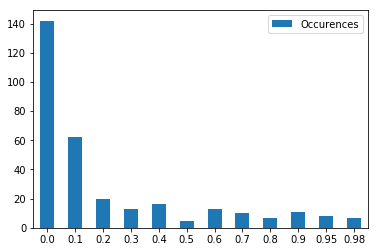

In [17]:
from sklearn.metrics import confusion_matrix
print occurences
accuracy = (TP+TN)/float(TP+TN+FP+FN)
precision = (TP+TN)/float(TP+TN+FP)
recall = (TP+TN)/float(TP+TN+FN)
fscore = (2*precision*recall)/float(precision+recall)
print("Accuracy: %.4f" % accuracy)
print("\nPrecision: %.4f\nRecall: %.4f\nF-score: %.4f" % (precision, recall, fscore))
print("\nTP %d, TN %d, FP %d, FN %d" % (TP, TN, FP, FN))

df = pd.DataFrame({'Occurences': occurences}, index=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98])
ax = df.plot.bar(rot=0)

confusion_matrix(y_xl, pred_labels)

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_xl, pred_labels)
precision = precision_score(y_xl, pred_labels)
recall = recall_score(y_xl, pred_labels)
fscore = f1_score(y_xl, pred_labels)
print("Accuracy: %.4f" % accuracy)
print("\nPrecision: %.4f\nRecall: %.4f\nF-score: %.4f" % (precision, recall, fscore))

confusion_matrix(y_xl, pred_labels)

Accuracy: 0.5064

Precision: 0.5385
Recall: 0.0892
F-score: 0.1530


array([[145,  12],
       [143,  14]])